In [96]:
import warnings
warnings.filterwarnings("ignore")

import re
import ast
import nltk
import random
import numpy as np
import pandas as pd
import json
from random import randint
from nltk import word_tokenize, FreqDist
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, plot_confusion_matrix

# Data Preprocessing

In [2]:
#loading dataset and removing unwanted features
dataset = pd.read_csv(f'Book_summary.csv', encoding= 'unicode_escape')
dataset = dataset.drop(['Publication Date', 'Wikibedia ID', 'Freebase ID'], axis=1)
dataset

,Book title,Book author,Genre,Summary
0,Animal Farm,George Orwell,"{""/m/016lj8"": ""Roman à clef"", ""/m/06nbt"": ""Sat...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,An Enquiry Concerning Human Understanding,David Hume,NaN,The argument of the Enquiry proceeds by a ser...
4,A Fire Upon the Deep,Vernor Vinge,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
...,...,...,...,...
16554,Under Wildwood,Colin Meloy,NaN,"Prue McKeel, having rescued her brother from ..."
16555,Transfer of Power,Vince Flynn,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
16556,Decoded,Jay-Z,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...
16557,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,NaN,Colbert addresses topics including Wall Stree...


In [3]:
#check for nulls and removing nans
dataset.isnull().count()
dataset = dataset.dropna(axis = 0)
dataset = dataset.reset_index(drop=True)
dataset

,Book title,Book author,Genre,Summary
0,Animal Farm,George Orwell,"{""/m/016lj8"": ""Roman à clef"", ""/m/06nbt"": ""Sat...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,A Fire Upon the Deep,Vernor Vinge,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
4,All Quiet on the Western Front,Erich Maria Remarque,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul B??umer, a G..."
...,...,...,...,...
12050,The Third Lynx,Timothy Zahn,"{""/m/06n90"": ""Science Fiction""}",The story starts with former government agent...
12051,Remote Control,Andy McNab,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction...",The series follows the character of Nick Ston...
12052,Transfer of Power,Vince Flynn,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
12053,Decoded,Jay-Z,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...


In [4]:
def cleaned_text(raw_text):
    raw_text = re.findall(r"[a-zA-Z]+", raw_text)
    raw_text = " ".join(raw_text).lower()
    tokens = word_tokenize(raw_text)
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return tokens

In [5]:
def convert_list_to_string(org_list, seperator=' '):
    """ Convert list to string, by joining all item in list with given separator.
        Returns the concatenated string """
    return seperator.join(org_list)

In [6]:
cleaned_dataset = dataset.copy()
cleaned_dataset.insert(loc=3, column='Book summary', value="")
unique_genres = {}

for index, row in cleaned_dataset.iterrows():
    row["Genre"] = list(ast.literal_eval(row["Genre"]).values())
    for item in row["Genre"]:
        if item not in unique_genres:
            unique_genres[item] = 1
        else:
            unique_genres[item] += 1
            
    tokens = cleaned_text(str(row['Summary']))
    # Convert list of strings to string
    row['Book summary'] = convert_list_to_string(tokens)

for index, row in cleaned_dataset.iterrows():
    if len(row["Genre"]) == 1:
        row["Genre"] = row["Genre"][0]
    else :
        max_ = 0
        pop_genre = ""
        for item in row["Genre"]:
            if unique_genres[item] > max_:
                max_ = unique_genres[item]
                pop_genre = item
        row["Genre"] = pop_genre

cleaned_dataset = pd.DataFrame(cleaned_dataset)
cleaned_dataset.drop('Summary', axis=1)

,Book title,Book author,Genre,Book summary
0,Animal Farm,George Orwell,Fiction,old major old boar manor farm call animal farm...
1,A Clockwork Orange,Anthony Burgess,Fiction,alex teenager living near future england lead ...
2,The Plague,Albert Camus,Fiction,text plague divided five part town oran thousa...
3,A Fire Upon the Deep,Vernor Vinge,Fiction,novel posit space around milky way divided con...
4,All Quiet on the Western Front,Erich Maria Remarque,War novel,book tell story paul b umer german soldier urg...
...,...,...,...,...
12050,The Third Lynx,Timothy Zahn,Science Fiction,story start former government agent frank comp...
12051,Remote Control,Andy McNab,Fiction,series follows character nick stone ex militar...
12052,Transfer of Power,Vince Flynn,Fiction,reader first meet rapp covert operation iran d...
12053,Decoded,Jay-Z,Autobiography,book follows rough chronological order switchi...


In [7]:
cleaned_dataset.groupby(["Genre"]).count()

,Book title,Book author,Book summary,Summary
Genre,,,,
Absurdist fiction,2,2,2,2
Adventure novel,56,56,56,56
Albino bias,1,1,1,1
Alien invasion,1,1,1,1
Alternate history,17,17,17,17
...,...,...,...,...
War novel,26,26,26,26
Western,9,9,9,9
Western fiction,8,8,8,8


# Feature Engineering

## TF-IDF

In [8]:
def tfidf_model(data):
    tfIdf_vectorizer = TfidfVectorizer(use_idf=True, min_df=0.05)

    tfidf_model = tfIdf_vectorizer.fit_transform(data)
    tfidf_features = pd.DataFrame(tfidf_model.toarray(), columns = tfIdf_vectorizer.get_feature_names())
    return tfidf_features

In [9]:
tfidf_features = tfidf_model(cleaned_dataset['Book summary'])
tfidf_features

,ability,able,accident,across,act,action,actually,adventure,affair,age,...,work,working,world,would,written,year,yet,york,young,younger
0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.016108,0.062023,0.014802,0.000000,0.0,0.012618,0.000000,0.0,0.030525,0.0
1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.058797,0.00000,0.0,0.0,...,0.000000,0.056115,0.000000,0.000000,0.0,0.068494,0.000000,0.0,0.082851,0.0
2,0.000000,0.000000,0.0,0.000000,0.045781,0.045051,0.000000,0.00000,0.0,0.0,...,0.032764,0.042053,0.000000,0.066288,0.0,0.000000,0.045515,0.0,0.031044,0.0
3,0.056044,0.000000,0.0,0.000000,0.052866,0.000000,0.101763,0.00000,0.0,0.0,...,0.000000,0.000000,0.139067,0.000000,0.0,0.088910,0.000000,0.0,0.035849,0.0
4,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.12049,0.0,0.0,...,0.000000,0.000000,0.149440,0.000000,0.0,0.000000,0.056480,0.0,0.038523,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12050,0.000000,0.142992,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.115878,0.0
12051,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.356158,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
12052,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
12053,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.088724,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0


## Doc2Vec

In [10]:
def doc2vec_model(data):  
    documents = [doc for doc in data]
    tagged_documents = [TaggedDocument(tokens, [i]) for i, tokens in enumerate(documents)]

    doc2vec_model = Doc2Vec(vector_size=300, min_count=2, epochs=40)
    doc2vec_model.build_vocab(tagged_documents)
    doc2vec_model.train(tagged_documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

    doc2vec_features = [doc2vec_model.infer_vector(doc.split()) for doc in documents]
    doc2vec_features = np.array(doc2vec_features)
    
    return pd.DataFrame(doc2vec_features)

In [11]:
doc2vec_features = doc2vec_model(cleaned_dataset["Book summary"])
doc2vec_features

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.001369,-0.000181,-0.000142,-0.000657,-0.000659,-0.001102,-0.001162,0.001056,0.000509,0.000821,...,0.001259,0.001364,0.001559,-0.000019,-0.001661,0.001508,-0.001010,0.000270,0.001024,-0.000769
1,-0.018928,-0.019791,-0.055352,-0.104665,0.083023,-0.104189,0.045205,-0.022748,0.073807,0.004586,...,-0.014948,0.041290,-0.008385,0.020743,0.064849,0.068969,0.039023,-0.025661,-0.053310,0.025527
2,0.000212,-0.001572,0.001155,-0.001532,-0.000244,-0.000373,0.000790,0.000693,-0.000891,0.001314,...,0.001477,-0.000315,-0.001354,0.000133,0.000572,0.001010,-0.000375,0.001378,0.001358,-0.001105
3,-0.001085,0.001241,-0.001594,0.001214,-0.001530,0.001378,0.000945,-0.001470,-0.000549,0.001308,...,-0.000480,-0.000278,0.000376,0.001021,-0.001501,-0.001217,-0.001073,-0.001118,0.000503,-0.001235
4,-0.051504,-0.077593,-0.153198,0.037441,0.067981,-0.114920,-0.000670,0.062737,0.122688,0.038552,...,-0.040132,0.067835,0.073534,0.027446,0.071027,0.011423,0.090608,0.060381,-0.053704,-0.086556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12050,-0.000889,0.001306,-0.001589,-0.000579,-0.001574,-0.001567,-0.000599,0.000271,-0.000046,0.000383,...,0.000905,0.000183,-0.000824,-0.001431,0.000557,0.000904,0.000779,0.000707,0.000691,0.001292
12051,-0.000240,0.001553,-0.000581,-0.001348,0.000923,0.000475,-0.001351,0.001514,-0.001630,0.000793,...,-0.001498,-0.000277,-0.001199,0.000606,-0.001079,-0.001487,-0.000581,0.000547,-0.001338,0.001104
12052,-0.009917,-0.014586,0.006288,-0.032830,0.018316,-0.047276,0.029504,-0.035378,-0.003222,0.002318,...,-0.008652,0.010574,0.009339,0.019000,0.026703,0.020328,0.026531,-0.004560,-0.054830,-0.031461
12053,-0.189895,-0.227069,0.171913,-0.053309,0.114817,-0.397022,0.236798,-0.008132,0.200691,0.114582,...,-0.012352,-0.020237,0.043638,0.098558,0.003107,-0.084713,0.079173,-0.011247,-0.578978,0.085896


## TF-IDF + Doc2Vec

In [12]:
tfidf_doc2vec_features = pd.concat([tfidf_features, doc2vec_features], axis=1)

# Clustering

In [13]:
import matplotlib.cm as cm
from scipy.spatial.distance import cosine
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from yellowbrick.cluster import KElbowVisualizer

In [14]:
model = KMeans(n_clusters = 30).fit_predict(doc2vec_features)

In [15]:
model2 = DBSCAN(eps=0.1, min_samples=3, metric="cosine").fit_predict(tfidf_doc2vec_features)

In [16]:
np.unique(model2)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
      dtype=int64)

In [17]:
indices = doc2vec_features[model2 == 0].index

In [18]:
indices

Int64Index([19, 1004, 1601, 1895, 10196, 10833], dtype='int64')

In [19]:
cosine_scores = []
for ind, val in enumerate(indices):
    cosine_score = cosine(doc2vec_features[model2 == 0].iloc[0], doc2vec_features[model2 == 0].iloc[ind])
    cosine_scores.append(cosine_score)
    
print(cosine_scores)

[0, 0.00903242826461792, 0.014035165309906006, 0.015880703926086426, 0.0030754804611206055, 0.00527036190032959]


In [20]:
np.argpartition(cosine_scores, 4)[:4]

array([4, 0, 5, 1], dtype=int64)

In [21]:
ya = doc2vec_features[model2 == 0].iloc[np.argpartition(cosine_scores, 4)[:4]].index

In [22]:
ya

Int64Index([10196, 19, 10833, 1004], dtype='int64')

In [23]:
cleaned_dataset.iloc[ya]

,Book title,Book author,Genre,Book summary,Summary
10196,The Last Egyptian,L. Frank Baum,Adventure novel,extensive diacritical mark appear novel publis...,The extensive diacritical marks appear in the...
19,The Trial,Franz Kafka,Fiction,thirtieth birthday chief financial officer ban...,"On his thirtieth birthday, the chief financia..."
10833,March to the Sea,John Ringo,Science Fiction,event marshad end previous book roger marine m...,After the events in Marshad (at the end of th...
1004,The Castle,Franz Kafka,Fiction,narrator k arrives village governed mysterious...,"The narrator, K., arrives in a village govern..."


In [24]:
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(20,50))

# visualizer.fit(tfidf_features_reduced)        # Fit the data to the visualizer
# visualizer.show()  

# Classification

In [25]:
# classif_dataset = cleaned_dataset.drop(['Book title', 'Book author', 'Summary'], axis=1)
# classif_dataset

In [26]:
def tfidf_model_classif(data_train, data_test):
    tfIdf_vectorizer = TfidfVectorizer(use_idf=True, min_df=0.05)

    tfidf_model = tfIdf_vectorizer.fit_transform(data_train)
    tfidf_train = pd.DataFrame(tfidf_model.toarray(), columns = tfIdf_vectorizer.get_feature_names())
    tfidf_test = tfIdf_vectorizer.transform(data_test)
    tfidf_test = pd.DataFrame(tfidf_test.toarray(), columns = tfIdf_vectorizer.get_feature_names())
    return tfidf_train, tfidf_test

In [27]:
def doc2vec_model_classif(data):  
    documents = [doc for doc in data]
    tagged_documents = [TaggedDocument(tokens, [i]) for i, tokens in enumerate(documents)]

    doc2vec_model = Doc2Vec(vector_size=300, min_count=2, epochs=40)
    doc2vec_model.build_vocab(tagged_documents)
    doc2vec_model.train(tagged_documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

    doc2vec_features = [doc2vec_model.infer_vector(doc.split()) for doc in documents]
    doc2vec_features = np.array(doc2vec_features)
    
    return pd.DataFrame(doc2vec_features)

In [30]:
def model_knn(x_train, y_train, x_test, y_test):
    classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2) #choosing Euclidean distance metric
    classifier.fit(x_train, y_train)
    ypred = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, ypred)*100
    print(f'K-NN: {accuracy}')
    
    return classifier, ypred, accuracy

In [31]:
def model_svm(x_train, y_train, x_test, y_test):
    cs = SVC(kernel = 'rbf', random_state = 0)
    cs.fit(x_train, y_train)
    ypred = cs.predict(x_test)
    accuracy = accuracy_score(y_test, ypred)*100
    print(f'K-NN: {accuracy}')
    return cs, ypred, accuracy

In [32]:
# tfidf_train_data, tfidf_test_data = tfidf_model_classif(dataset_train["Book summary"], dataset_test["Book summary"])

In [33]:
# doc2vec_train_data = doc2vec_model_classif(dataset_train["Book summary"])
# doc2vec_test_data = doc2vec_model_classif(dataset_test["Book summary"])

In [34]:
# svm_tfidf_model, y_pred_tfidf, accuracy_tfidf = model_svm(tfidf_train_data, dataset_train['Genre'], tfidf_test_data, dataset_test['Genre'])

In [35]:
# svm_tfidf_model, y_pred_tfidf, accuracy_tfidf = model_svm(doc2vec_train_data, dataset_train['Genre'], doc2vec_test_data, dataset_test['Genre'])

In [36]:
# print(classif_dataset.groupby('Genre').count())

In [37]:
# classif_dataset['Genre'].value_counts()

In [38]:
# def plt_bar(labels_name, yvalues, title, xlabel, ylabel):
#     fig, ax = plt.subplots(figsize=(20, 20))
#     plt.bar(labels_name, yvalues)
#     plt.title(title, fontsize = 'x-large')
#     plt.ylabel(ylabel, fontsize = 'x-large')
#     plt.xlabel(xlabel, fontsize = 'x-large')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
#     plt.show()

In [39]:
# plt_bar(list(set(classif_dataset['Genre'])), classif_dataset['Genre'].value_counts(), 'Genre counts', 'Genres', 'Amount')

In [40]:
# new_data = classif_datase[classif_datase.Genre >= 0]

# preprocessing data For classification process
preparing the data for multi label classification

##### The genre row contains data stored in the Dictionary format
so, the following steps is to convert this data to a dictionary format to be accessible

In [43]:
list_genre = []
for i in dataset['Genre']:
    list_genre.append(list(json.loads(i).values())) # reading each cell's content and parse it

In [44]:
# creating the new Dataset dataframe
classif_dataset = pd.DataFrame(list(zip(cleaned_dataset['Book summary'].values, list_genre)), columns = ["Summary", "Genre"])
classif_dataset

,Summary,Genre
0,old major old boar manor farm call animal farm...,"[Roman à clef, Satire, Children's literature, ..."
1,alex teenager living near future england lead ...,"[Science Fiction, Novella, Speculative fiction..."
2,text plague divided five part town oran thousa...,"[Existentialism, Fiction, Absurdist fiction, N..."
3,novel posit space around milky way divided con...,"[Hard science fiction, Science Fiction, Specul..."
4,book tell story paul b umer german soldier urg...,"[War novel, Roman à clef]"
...,...,...
12050,story start former government agent frank comp...,[Science Fiction]
12051,series follows character nick stone ex militar...,"[Thriller, Fiction, Suspense]"
12052,reader first meet rapp covert operation iran d...,"[Thriller, Fiction]"
12053,book follows rough chronological order switchi...,[Autobiography]


##### Check for nulls
we have 221 Genre covered in this dataset

In [45]:
# print(classif_dataset.isnull().values.any())
# len(set(sum(list_genre,[])))

In [46]:
def plt_bar(labels_name, yvalues, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(15, 12))
    plt.bar(labels_name, yvalues)
    plt.title(title, fontsize = 'x-large')
    plt.ylabel(ylabel, fontsize = 'x-large')
    plt.xlabel(xlabel, fontsize = 'x-large')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()

In [47]:
all_genres = sum(list_genre, [])
len(set(all_genres))

221

In [48]:
all_genres = nltk.FreqDist(all_genres) 
all_genres

FreqDist({'Fiction': 4714, 'Speculative fiction': 4292, 'Science Fiction': 2725, 'Novel': 2379, 'Fantasy': 2323, "Children's literature": 1999, 'Mystery': 1358, 'Suspense': 761, 'Young adult literature': 736, 'Crime Fiction': 732, ...})

In [49]:
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

In [51]:
g = all_genres_df.nlargest(columns="Count", n = 50) 

No handles with labels found to put in legend.


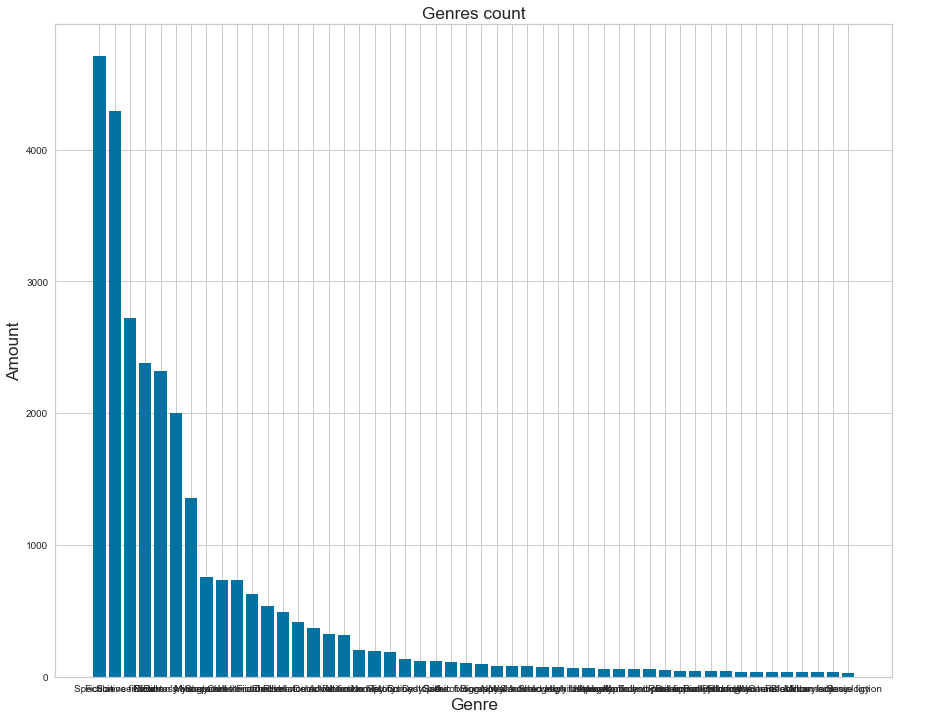

In [52]:
plt_bar(g['Genre'], g['Count'], 'Genres count', 'Genre', 'Amount')

##### to be able to classify multilabel data we have to obtain a dummy set
using MultiLabelBinarizer() well do that

In [59]:
binarizer = MultiLabelBinarizer()
binarized_target = binarizer.fit_transform(classif_dataset['Genre'])
binarized_target

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [79]:
def train_test_data(xdata, ydata):
    x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size = 0.3, random_state=0)
    x_train = x_train.reset_index(drop = True)
    x_test = x_test.reset_index(drop = True)
    return x_train, x_test, y_train, y_test

In [80]:
xtrain, xtest, ytrain, ytest = train_test_data(classif_dataset['Summary'], binarized_target)

In [82]:
tfidf_train_data, tfidf_test_data = tfidf_model_classif(xtrain, xtest)

In [84]:
doc2vec_train_data = doc2vec_model_classif(xtrain)
doc2vec_test_data = doc2vec_model_classif(xtest)

# Genre prediction model

In [128]:
# from sklearn.naive_bayes import MultinomialNB

# model = MultinomialNB()
# clf = OneVsRestClassifier(model)

In [129]:
# clf.fit(tfidf_train_data, ytrain)
# ypred_tfidf = clf.predict(tfidf_test_data)
# ypred_tfidf

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [130]:
# accuracy_score(ytest, ypred_tfidf)

0.035941387890517006

In [136]:
# binarizer.inverse_transform(ypred_tfidf)[200]


('Speculative fiction',)

In [121]:
# from skmultilearn.problem_transform import BinaryRelevance
# from sklearn.naive_bayes import MultinomialNB

# binary_rel_clf = BinaryRelevance(MultinomialNB())

In [122]:
# binary_rel_clf.fit(tfidf_train_data, ytrain)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [124]:
# br_prediction = binary_rel_clf.predict(tfidf_test_data)
# accuracy_score(ytest, br_prediction)

0.035941387890517006